In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from scipy.special import boxcox1p
import lightgbm as lgb
from tqdm import tqdm_notebook
import scipy
import optuna
import matplotlib.pyplot as plt 
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

In [2]:
#計算分數
def cal_score(y_pred,y_true):
    score_df = pd.DataFrame({'y_pred':y_pred,'y_true':y_true})
    score_df['diff_percentage'] = np.abs((score_df['y_pred'] - score_df['y_true']) / score_df['y_true'])
    score_df.loc[score_df['diff_percentage'] <= 0.1,'label'] = 1
    score_df.loc[score_df['diff_percentage'] > 0.1,'label'] = 0
    hit_rate = score_df['label'].sum() / len(y_pred)
    mape = score_df['diff_percentage'].sum() / len(y_pred)
    if mape > 1:
        mape = 1
    final_score = hit_rate * 10000 + (1-mape)
    return final_score

def standard_remove_outlier(train_data, feature_name):
    if feature_name == "land_area":
        log_feature = np.log(train_data[feature_name]).replace([np.inf, -np.inf], 0)
        feature_mean = log_feature.mean()
        feature_std = log_feature.std()
        train_data['standard_outlier'] = (log_feature - feature_mean) / feature_std
        drop_index = train_data.loc[(train_data['standard_outlier']>3)|(train_data['standard_outlier']<-3)].index
    else:
        log_feature = np.log(train_data[feature_name])
        feature_mean = log_feature.mean()
        feature_std = log_feature.std()
        train_data['standard_outlier'] = (log_feature - feature_mean) / feature_std
        drop_index = train_data.loc[(train_data['standard_outlier']>3)|(train_data['standard_outlier']<-3)].index
    return drop_index

In [3]:
train_data = pd.read_csv("train_avm.csv")

train_data = train_data.drop(standard_remove_outlier(train_data, 'total_price'),axis=0)
train_data = train_data.drop('standard_outlier',axis=1)
train_data = train_data.reset_index(drop=True)

train_data = train_data.drop(standard_remove_outlier(train_data, 'building_area'),axis=0)
train_data = train_data.drop('standard_outlier',axis=1)
train_data = train_data.reset_index(drop=True)

train_data = train_data.drop(standard_remove_outlier(train_data, 'land_area'),axis=0)
train_data = train_data.drop('standard_outlier',axis=1)
train_data = train_data.reset_index(drop=True)

test_data = pd.read_csv("test_avm.csv")
total_data = pd.concat([train_data,test_data],sort=False).reset_index(drop=True)

C:\Users\champ\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
# 交易樓層高度比例
total_data['high_ratio'] = total_data['txn_floor'] / total_data['total_floor']
total_data['high_ratio'] = total_data['high_ratio'].fillna(0)

#因為有缺值的都在總樓層 5 層以下，所以推測是別墅 building type皆為4
total_data['txn_floor'] = total_data['txn_floor'].fillna(-1)
total_data['txn_floor'] = total_data['txn_floor'].astype('category')

# 用city中位數補缺失值
city_income_median = total_data.groupby(by="city")['village_income_median'].median().reset_index().rename(columns={'village_income_median':'city_income_median'})
total_data = total_data.merge(city_income_median, on="city", how="left")
total_data.loc[total_data['village_income_median'].isnull(), 'village_income_median'] = total_data.loc[total_data['village_income_median'].isnull(), 'city_income_median']

#車位價格 填補為0 因為都是停放方式2且area都為NAN
total_data['parking_price'] = total_data['parking_price'].fillna(0)

# 車位面積(暫定)
total_data['parking_area'] = total_data['parking_area'].fillna(0)

# 屋齡
total_data['house_year'] = (total_data['txn_dt'] - total_data['building_complete_dt'])/365

# 新地點
total_data['str_city'] = total_data['city'].apply(lambda x : str(x))
total_data['str_town'] = total_data['town'].apply(lambda x : str(x))
total_data['str_village'] = total_data['village'].apply(lambda x : str(x))
total_data['new_village'] = total_data['str_city'] + "_" + total_data['str_town'] + "_" + total_data['str_village']
le = LabelEncoder()
total_data['new_village'] = le.fit_transform(total_data['new_village'])
total_data['new_town'] = total_data['str_city'] + "_" + total_data['str_town']
total_data['new_town'] = le.fit_transform(total_data['new_town'])

# 星期幾
total_data['weekday'] = total_data['txn_dt'] % 7
# 幾月
total_data['month'] = (total_data['txn_dt'] % 365 / 30.4167).apply(lambda x:np.floor(x))
# 季度
total_data['quarter'] = (total_data['txn_dt'] % 365 / 91.25).apply(lambda x:np.floor(x))

# 點位數轉換成密度
number_list = ["I", "II", "III", "IV", "V", "VI", "VII", "VIII", "IX", "X", "XI", "XII", "XIII", "XIV"]
radius_list = ["10", "50", "100", "250", "500", "1000"]
for number in number_list:
    for radius in radius_list:
        column_name = number + "_" + radius
        total_data[column_name] = total_data[column_name] / (np.pi*(int(radius)**2))
        
# 土地建物比
total_data['build_land_ratio'] = total_data['land_area'] / total_data['building_area']

#每一層樓的面積
total_data['every_floor_area'] = total_data['building_area'] / total_data['total_floor']

#對目標變數取log
total_data['total_price'] = np.log(total_data['total_price'] / total_data['building_area'])

# 將類別特徵轉為類別
total_data['building_material'] = total_data['building_material'].astype('category')
total_data['city'] = total_data['city'].astype('category')
total_data['town'] = total_data['town'].astype('category')
total_data['new_town'] = total_data['new_town'].astype('category')
total_data['new_village'] = total_data['new_village'].astype('category')
total_data['building_type'] = total_data['building_type'].astype('category')
total_data['building_use'] = total_data['building_use'].astype('category')
total_data['parking_way'] = total_data['parking_way'].astype('category')
total_data['weekday'] = total_data['weekday'].astype('category')
total_data['month'] = total_data['month'].astype('category')
total_data['quarter'] = total_data['quarter'].astype('category')

new_train_data = total_data[:len(train_data)]
new_test_data = total_data[len(train_data):].drop('total_price',axis=1)

In [5]:
features = ['txn_floor', 'txn_dt', 'total_floor', 'house_year', 'building_material', 'city', 'new_town', 'new_village',
            'building_type', 'building_use', 'parking_way', 'land_area', 'building_area', 'town_population',
            'town_area', 'town_population_density', 'doc_Rate', 'master_rate', 'bachelor_rate', 'highschool_rate', 
            'jobschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_date', 'marriage_rate', 'divorce_rate',
            'high_ratio','village_income_median', 'parking_price', 'parking_area', 'lat', 'lon',
            'weekday', 'month', 'quarter', 'build_land_ratio', 'every_floor_area']
I_features = ['I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000']
II_features = ['II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000']
III_features = ['III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000']
IV_features = ['IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000']
V_features = ['V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000']
VI_features = ['VI_10', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000']
VII_features = ['VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000']
VIII_features = ['VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000']
IX_features = ['IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000']
X_features = ['X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000']
XI_features = ['XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000']
XII_features = ['XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000']
XIII_features = ['XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000']
XIV_features = ['XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000']
N_features = ['N_50', 'N_500', 'N_1000']
distance_features = ['I_MIN', 'II_MIN', 'III_MIN', 'IV_MIN', 'V_MIN', 'VI_MIN', 'VII_MIN', 'VIII_MIN', 'IX_MIN', 'X_MIN', 
                    'XI_MIN', 'XII_MIN', 'XIII_MIN', 'XIV_MIN']

features.extend(I_features)
features.extend(II_features)
features.extend(III_features)
features.extend(IV_features)
features.extend(V_features)
features.extend(VI_features)
features.extend(VII_features)
features.extend(VIII_features)
features.extend(IX_features)
features.extend(XI_features)
features.extend(XII_features)
features.extend(XIII_features)
features.extend(XIV_features)
features.extend(N_features)
features.extend(distance_features)

X = new_train_data[features]
new_test_data = new_test_data[features]
y = new_train_data['total_price']
kf = KFold(n_splits=10)

params = {
    'task':'train',
    'boosting_type':'gbdt',
    'objective':'mse',
    'metric':'mape',
    
'learning_rate': 0.005485085888017132,
 'num_boost_round': 11013,
 'lambda_l1': 7.057950003335214e-07,
 'lambda_l2': 0.4493742362548712,
 'num_leaves': 394,
 'feature_fraction': 0.4320860596138761,
 'bagging_fraction': 0.8697183526079256,
 'bagging_freq': 6,
 'min_child_samples': 38
}

average_test_predict_result = np.zeros(len(test_data))
train_score_list = []
valid_score_list = []
for epoch, (train_index, valid_index) in enumerate(kf.split(X,y)):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_valid,y_valid)
    lightgbm = lgb.train(params,train_set=lgb_train,valid_sets=lgb_valid,
                         early_stopping_rounds=1000,verbose_eval=False)
    
    train_predict_result = np.exp(lightgbm.predict(X_train))* X_train['building_area']
    valid_predict_result = np.exp(lightgbm.predict(X_valid))* X_valid['building_area']
    
    train_score = cal_score(train_predict_result,np.exp(y_train)* X_train['building_area'])
    validation_score = cal_score(valid_predict_result,np.exp(y_valid)* X_valid['building_area'])
    
    print('Epoch {} train score : {}  valid score : {}'.format(epoch,train_score,validation_score))
    train_score_list.append(train_score)
    valid_score_list.append(validation_score)
    average_test_predict_result += np.exp(lightgbm.predict(new_test_data))* new_test_data['building_area']

average_test_predict_result = average_test_predict_result / 10

print('train cv scores:',np.mean(train_score_list))
print('train cv scores std:',np.std(train_score_list))
print('valid cv scores:',np.mean(valid_score_list))
print('valid cv scores std:',np.std(valid_score_list))

C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16111
[LightGBM] [Info] Number of data points in the train set: 33368, number of used features: 133
[LightGBM] [Info] Start training from score 13.578710


C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Epoch 0 train score : 9992.605761377554  valid score : 6001.413002177584


C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16111
[LightGBM] [Info] Number of data points in the train set: 33368, number of used features: 132
[LightGBM] [Info] Start training from score 13.575616


C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Epoch 1 train score : 9993.504778282313  valid score : 5966.359986831628


C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16109
[LightGBM] [Info] Number of data points in the train set: 33368, number of used features: 133
[LightGBM] [Info] Start training from score 13.580067


C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Epoch 2 train score : 9993.804492663108  valid score : 5955.565869844258


C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008661 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16123
[LightGBM] [Info] Number of data points in the train set: 33368, number of used features: 133
[LightGBM] [Info] Start training from score 13.577319


C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Epoch 3 train score : 9992.605722375114  valid score : 5888.13903486169


C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16139
[LightGBM] [Info] Number of data points in the train set: 33368, number of used features: 132
[LightGBM] [Info] Start training from score 13.577153


C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Epoch 4 train score : 9992.90543285287  valid score : 6044.566839821525


C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16148
[LightGBM] [Info] Number of data points in the train set: 33368, number of used features: 132
[LightGBM] [Info] Start training from score 13.576052


C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Epoch 5 train score : 9992.605762606996  valid score : 5896.2325251063285


C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040535 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16127
[LightGBM] [Info] Number of data points in the train set: 33369, number of used features: 132
[LightGBM] [Info] Start training from score 13.576899


C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Epoch 6 train score : 9992.905613507963  valid score : 6021.921456586389


C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008856 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16116
[LightGBM] [Info] Number of data points in the train set: 33369, number of used features: 132
[LightGBM] [Info] Start training from score 13.578443


C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Epoch 7 train score : 9992.006596358378  valid score : 5984.147034999284


C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16141
[LightGBM] [Info] Number of data points in the train set: 33369, number of used features: 132
[LightGBM] [Info] Start training from score 13.578708


C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Epoch 8 train score : 9992.60597952318  valid score : 5881.643438581471


C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 16122
[LightGBM] [Info] Number of data points in the train set: 33369, number of used features: 132
[LightGBM] [Info] Start training from score 13.578288


C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
C:\Users\champ\Anaconda3\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Epoch 9 train score : 9992.905642564416  valid score : 5897.8291021479135
train cv scores: 9992.845578211189
train cv scores std: 0.4794485104614863
valid cv scores: 5953.781829095808
valid cv scores std: 56.7385654582405


In [8]:
feature_importance = pd.DataFrame({'feature':X.columns,'score':lightgbm.feature_importance()}).sort_values(by='score',ascending=False)
feature_importance['ratio'] = feature_importance['score'] / feature_importance['score'].sum()
feature_importance

,feature,score,ratio
1,txn_dt,161065,0.037214
36,build_land_ratio,136093,0.031444
3,house_year,135762,0.031368
37,every_floor_area,114786,0.026521
12,building_area,110591,0.025552
130,XII_MIN,105756,0.024435
132,XIV_MIN,96499,0.022296
128,X_MIN,92457,0.021362
129,XI_MIN,90094,0.020816
125,VII_MIN,89643,0.020712


In [25]:
answer = pd.DataFrame({'building_id':test_data['building_id'],'total_price':average_test_predict_result.values})
answer.to_csv('result_avm.csv',index=None)

# 視覺化

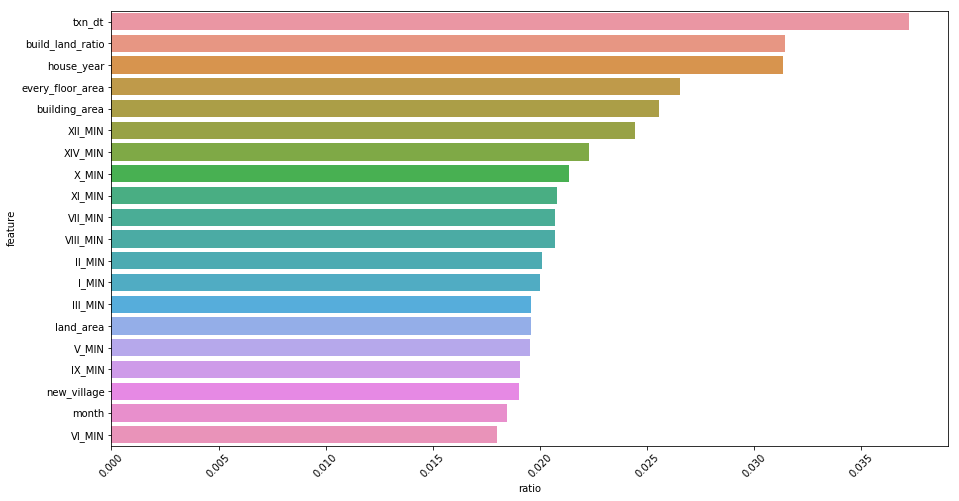

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 8))
plt.xticks(rotation=45)
sns.barplot(x='ratio', y='feature', data=feature_importance[:20], orient="h")